## Import Libraries

In [ ]:
import re
import string
import fasttext
import numpy as np
import pandas as pd
from datetime import datetime
from langdetect import detect
import math

import nltk
# nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from scipy import sparse

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


## Reviews Data

In [ ]:
reviews = pd.read_csv('cleaned_reviews.csv', lineterminator='\n')
reviews

,listing_id,comments
0,2595,Notre séjour de trois nuits.\r Nous avons appr...
1,2595,Great experience.
2,2595,I've stayed with my friend at the Midtown Cast...
3,2595,"We've been staying here for about 9 nights, en..."
4,2595,We had a wonderful stay at Jennifer's charming...
...,...,...
908633,54068505,This accommodation is really spacious and cozy...
908634,54068618,"Trenton is a very polite, supportive and nice ..."
908635,54069262,The place looks nothing like the way it looks ...
908636,54070458,I will recommend this place to anyone going to...


## Listings Data

In [ ]:
listings = pd.read_csv('dist_cleaned_listings.csv')
listings

,id,name,description,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,amenities_str,name_lang,description_lang,host_months,dist_to_subway
0,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,2008-12-07,a few days or more,0.0,64.0,f,1.0,...,4.80,4.71,4.64,f,1,"""Hot water"", ""Iron"", ""Children\u2019s books an...",en,en,157,0.401337
1,5121,BlissArtsSpace!,The space HELLO EVERYONE AND THANKS FOR VISI...,No Data,2009-02-03,within an hour,100.0,100.0,f,1.0,...,4.91,4.47,4.52,f,2,"""Heating"", ""Air conditioning"", ""Long term stay...",en,en,155,0.464577
2,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,No Data,2009-02-03,No Data,NaN,25.0,f,1.0,...,5.00,4.50,5.00,f,1,"""Cable TV"", ""TV with standard cable"", ""Outdoor...",en,en,155,0.337801
3,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",2009-03-03,within a few hours,100.0,100.0,f,1.0,...,4.42,4.87,4.36,f,1,"""Hot water"", ""Body soap"", ""Iron"", ""Lock on bed...",ja,en,155,0.211683
4,5203,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,2009-02-05,No Data,NaN,NaN,f,1.0,...,4.95,4.94,4.92,f,1,"""Fire extinguisher"", ""Hot water"", ""Carbon mono...",en,en,155,0.058776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32991,54144941,*NEW* Private Room near Prospect Park Brooklyn,Take it easy at this unique and tranquil getaw...,No Data,2021-10-28,within an hour,100.0,100.0,f,10.0,...,0.00,0.00,0.00,t,13,"""Free parking on premises"", ""Lock on bedroom d...",en,en,3,0.857660
32992,54146235,Micro Hostel in The Heart of Chelsea New York,Everything you want to explore is right outsid...,No Data,2017-10-20,within a day,100.0,100.0,f,0.0,...,0.00,0.00,0.00,t,4,"""Wifi"", ""Building staff"", ""Long term stays all...",en,en,51,0.218969
32993,54148518,Time Square New York -Share Room,New York!!! The trendiest city in the world. ...,The center of Manhattan! There are many uniqu...,2021-12-16,within a few hours,100.0,100.0,f,1.0,...,0.00,0.00,0.00,t,2,"""Hot water"", ""Ceiling fan"", ""Shower gel"", ""Ref...",en,en,1,0.230963
32994,54150715,Private PATIO in PRIVATE Room | 5mins to Manha...,No Data,No Data,2020-03-05,No Data,NaN,NaN,f,12.0,...,0.00,0.00,0.00,f,1,"""Fire extinguisher"", ""Hot water"", ""Carbon mono...",en,en,22,0.436309


## Detect Language

In [ ]:
model = fasttext.load_model('lid.176.ftz')

def detect_lang(x):
    lang = model.predict(x, k=1)[0][0].split('__')[-1]
    return lang

In [ ]:
# Check if reviews are in English
reviews['language'] = reviews['comments'].apply(lambda x: detect_lang(x))
reviews.head()

,listing_id,comments,language
0,2595,Notre séjour de trois nuits.\r Nous avons appr...,fr
1,2595,Great experience.,en
2,2595,I've stayed with my friend at the Midtown Cast...,en
3,2595,"We've been staying here for about 9 nights, en...",en
4,2595,We had a wonderful stay at Jennifer's charming...,en


In [ ]:
# Check if listings' name and description are in English
check_language = ['name', 'description']
check_language_new_col= ['name_lang', 'description_lang']

for i in range(len(check_language)):
    listings[check_language_new_col[i]] = listings[check_language[i]].apply(lambda x: detect_lang(x))

listings.head()

,id,name,description,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,amenities_str,name_lang,description_lang,host_months,dist_to_subway
0,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,2008-12-07,a few days or more,0.0,64.0,f,1.0,...,4.80,4.71,4.64,f,1,"""Hot water"", ""Iron"", ""Children\u2019s books an...",en,en,157,0.401337
1,5121,BlissArtsSpace!,The space HELLO EVERYONE AND THANKS FOR VISI...,No Data,2009-02-03,within an hour,100.0,100.0,f,1.0,...,4.91,4.47,4.52,f,2,"""Heating"", ""Air conditioning"", ""Long term stay...",en,en,155,0.464577
2,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,No Data,2009-02-03,No Data,NaN,25.0,f,1.0,...,5.00,4.50,5.00,f,1,"""Cable TV"", ""TV with standard cable"", ""Outdoor...",en,en,155,0.337801
3,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",2009-03-03,within a few hours,100.0,100.0,f,1.0,...,4.42,4.87,4.36,f,1,"""Hot water"", ""Body soap"", ""Iron"", ""Lock on bed...",ja,en,155,0.211683
4,5203,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,2009-02-05,No Data,NaN,NaN,f,1.0,...,4.95,4.94,4.92,f,1,"""Fire extinguisher"", ""Hot water"", ""Carbon mono...",en,en,155,0.058776


## Remove Non-English Records

We are aware that detect_lang model used is not 100% accurate. Since we have much fewer listings than reviews, we will further inspect listings with non-English names and descriptions. We will manually check through the names and descriptions of such listings and only remove those that are correctly labelled as non-English. For reviews, we will drop those which have been identified by the model as non-English.

In [ ]:
listings[(listings['name_lang'] != 'en') & (listings['description_lang'] != 'en')]
# 163 listings with non-English name and description

,id,name,description,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,amenities_str,name_lang,description_lang,host_months,dist_to_subway
3518,4948928,HUGE 1 BED@TIMES SQUARE@BRAND NEW!!,PLEASE DON'T TRY TO BOOK THE APARTMENT BEFORE ...,No Data,2011-08-03,within a few hours,84.0,38.0,f,7.0,...,4.50,4.50,4.00,f,8,"""Cable TV"", ""Fire extinguisher"", ""TV with stan...",it,de,126,0.794962
3802,5637556,HUGE ONE BED APARTMENT! TIMES SQ!!!WEST 39TH!!!,THIS APARTMENT IS LOCATED AT WEST 39TH AND NOT...,No Data,2011-08-03,within a few hours,84.0,38.0,f,7.0,...,0.00,0.00,0.00,f,8,"""Cable TV"", ""Fire extinguisher"", ""TV with stan...",ja,de,126,0.774456
6474,9765944,SUNNY BEDROOM IN BROOKLYN BROWNSTON,PRIVATE BEDROOM ON THE TOP FLOOR OF A THREE ST...,No Data,2013-12-01,No Data,NaN,NaN,f,3.0,...,0.00,0.00,0.00,f,1,"""Fire extinguisher"", ""Smoke alarm"", ""Essential...",de,ja,98,0.235837
6601,9866039,"Modern, Large & Cozy 1 BR NYC Apt","Spacious, modern & quiet apartment in doormen ...",Midtown East is extremely convenient as it is ...,2010-12-09,No Data,NaN,100.0,f,1.0,...,5.00,5.00,4.78,f,1,"""Hot water"", ""Body soap"", ""Iron"", ""Refrigerato...",pl,fr,133,0.375674
14899,27141191,NewlyBuilt+Terrace 3min▶︎Subway 30min Manhattan,"This apartment is located 3min from subway ""Gr...",Grand Ave is asian oriented community. You can...,2014-08-01,within an hour,100.0,85.0,f,190.0,...,5.00,4.00,4.00,f,150,"""Lock on bedroom door"", ""Heating"", ""Air condit...",pt,ja,90,0.178820
17330,32591771,Room with a Terrace + 3min ➡︎ SubwayM/R Grand Ave,"This apartment is located 3min from subway ""Gr...",Grand Ave is asian oriented community. You can...,2014-08-01,within an hour,100.0,85.0,f,190.0,...,0.00,0.00,0.00,f,150,"""Fire extinguisher"", ""Lock on bedroom door"", ""...",pt,ja,90,0.212089
20740,39982698,SPACIOUS 1 BEDROOM APT IN HARLEM,1 BEDROOM FULLY FURNISHED AVAILABLE FOR WEEK T...,HARLEM NEIGHBORHOOD WALKING DISTANCE TO COFFEE...,2017-04-30,within an hour,100.0,94.0,f,1.0,...,4.71,4.29,4.71,f,1,"""Hot water"", ""Iron"", ""Refrigerator"", ""Outdoor ...",pt,uk,57,0.223369
25090,47276663,"SPACIOUS PRIVATE ROOM!!!, 30 mins to Manhattan",NO GUEST ALLOW ONLY REGISTER PEOPLE CAN ENTER...,No Data,2019-04-23,within an hour,100.0,78.0,t,2.0,...,4.96,4.89,4.81,f,2,"""Hot water"", ""Body soap"", ""Shower gel"", ""Refri...",es,hu,33,0.236168
25956,48506346,"COZY, COMFORT AT SPRINGFIELD GARDENS",2 BEDROOM APARTMENT NEAR JFK AIRPORT. COZY! ...,No Data,2018-07-25,a few days or more,17.0,9.0,f,1.0,...,1.00,1.00,1.00,t,1,"""Iron"", ""KENMORE refrigerator"", ""Hot water ket...",tr,it,42,4.941401


In [ ]:
# By manual inspection, some listings were incorrectly labelled as non-English
eng_listings = [4948928, 5637556, 9765944, 9866039, 27141191, 32591771, 
                39982698, 47276663, 48506346]

for l in eng_listings:
    listings.loc[listings['id'] == l, ['name_lang', 'description_lang']] = 'en'

In [ ]:
# Drop listings with non-English names and descriptions
listings = listings[~((listings['name_lang'] != 'en') & (listings['description_lang'] != 'en'))]

In [ ]:
# Drop 81019 reviews which are non-English
reviews = reviews[~(reviews['language'] != 'en')]

## Remove Web Links

In [ ]:
def remove_weblinks(txt):
    txt = re.sub(r'https\S+', '', txt)
    txt = re.sub(r'http\S+', '', txt)
    txt = re.sub(r'www\S+', '', txt)
    txt = txt.replace('https', '')
    txt = txt.replace('http', '')
    txt = txt.replace('www', '')
    return txt

In [ ]:
# Remove from listing descriptions and reviews
listings['description'] = listings['description'].apply(remove_weblinks)
reviews['comments'] = reviews['comments'].apply(remove_weblinks)

<ipython-input-12-f12a8d00fec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['comments'] = reviews['comments'].apply(remove_weblinks)


## Length of Words in Reviews

In [ ]:
# Count the number of words in review comments
reviews['num_words'] = reviews['comments'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))
reviews.head()

<ipython-input-13-9ca1fa855049>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['num_words'] = reviews['comments'].apply(lambda x: sum([i.strip(string.punctuation).isalpha() for i in x.split()]))


,listing_id,comments,language,num_words
1,2595,Great experience.,en,2
2,2595,I've stayed with my friend at the Midtown Cast...,en,85
3,2595,"We've been staying here for about 9 nights, en...",en,60
4,2595,We had a wonderful stay at Jennifer's charming...,en,23
5,2595,Hi to everyone!\r Would say our greatest compl...,en,96


## Calculate Number of Months Since Joining Airbnb as Host

In [ ]:
# Calculate the number of months since host was registered onto Airbnb based on 'host_since'
date_scraped = datetime.fromisoformat('2022-01-03')
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['host_months'] = date_scraped - listings['host_since']
listings['host_months'] = (listings['host_months'] / np.timedelta64(1,'M'))

# Round up the number of months since host registered on Airbnb
listings['host_months'] = np.ceil(listings['host_months']).astype(int)
listings.head()

,id,name,description,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,amenities_str,name_lang,description_lang,host_months,dist_to_subway
0,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,2008-12-07,a few days or more,0.0,64.0,f,1.0,...,4.80,4.71,4.64,f,1,"""Hot water"", ""Iron"", ""Children\u2019s books an...",en,en,157,0.401337
1,5121,BlissArtsSpace!,The space HELLO EVERYONE AND THANKS FOR VISI...,No Data,2009-02-03,within an hour,100.0,100.0,f,1.0,...,4.91,4.47,4.52,f,2,"""Heating"", ""Air conditioning"", ""Long term stay...",en,en,155,0.464577
2,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,No Data,2009-02-03,No Data,NaN,25.0,f,1.0,...,5.00,4.50,5.00,f,1,"""Cable TV"", ""TV with standard cable"", ""Outdoor...",en,en,155,0.337801
3,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",2009-03-03,within a few hours,100.0,100.0,f,1.0,...,4.42,4.87,4.36,f,1,"""Hot water"", ""Body soap"", ""Iron"", ""Lock on bed...",ja,en,155,0.211683
4,5203,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,2009-02-05,No Data,NaN,NaN,f,1.0,...,4.95,4.94,4.92,f,1,"""Fire extinguisher"", ""Hot water"", ""Carbon mono...",en,en,155,0.058776


In [ ]:
# Store processed listings and reviews as csv
listings.to_csv('processed_listings.csv', index=False)
reviews.to_csv('processed_reviews.csv', index=False)

## Combining Listings & Reviews

In [ ]:
listings = pd.read_csv('processed_listings.csv')
reviews = pd.read_csv('processed_reviews.csv', lineterminator='\n')

In [ ]:
reviews.columns = ['id', 'comments', 'num_words', 'language']

combined = pd.merge(listings, reviews, on='id', how='left')
combined = combined.drop(['num_words', 'language'], axis=1)
combined_comments = combined.groupby('id')['comments'].apply(lambda x: list(x)).reset_index()
combined_comments['comments'] = combined_comments['comments'].apply(lambda x: [] if x[0] != x[0] else x)
combined = pd.merge(listings, combined_comments, on='id', how='left')

combined

,id,name,description,neighborhood_overview,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,amenities_str,name_lang,description_lang,host_months,dist_to_subway,comments
0,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,2008-12-07,a few days or more,0.0,64.0,f,1.0,...,4.71,4.64,f,1,"""Hot water"", ""Iron"", ""Children\u2019s books an...",en,en,157,0.401337,"[lisa is a wonderful, kind and thoughtful host..."
1,5121,BlissArtsSpace!,The space HELLO EVERYONE AND THANKS FOR VISI...,No Data,2009-02-03,within an hour,100.0,100.0,f,1.0,...,4.47,4.52,f,2,"""Heating"", ""Air conditioning"", ""Long term stay...",en,en,155,0.464577,"[Simple place, super nice guy., Great guy with..."
2,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,No Data,2009-02-03,No Data,NaN,25.0,f,1.0,...,4.50,5.00,f,1,"""Cable TV"", ""TV with standard cable"", ""Outdoor...",en,en,155,0.337801,[My family had a wonderful stay at Rebecca and...
3,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",2009-03-03,within a few hours,100.0,100.0,f,1.0,...,4.87,4.36,f,1,"""Hot water"", ""Body soap"", ""Iron"", ""Lock on bed...",ja,en,155,0.211683,"[MR. Kasai was a grreat host , very helpful an..."
4,5203,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,2009-02-05,No Data,NaN,NaN,f,1.0,...,4.94,4.92,f,1,"""Fire extinguisher"", ""Hot water"", ""Carbon mono...",en,en,155,0.058776,[Emmie and her family are exceptional hosts. T...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32991,54144941,*NEW* Private Room near Prospect Park Brooklyn,Take it easy at this unique and tranquil getaw...,No Data,2021-10-28,within an hour,100.0,100.0,f,10.0,...,0.00,0.00,t,13,"""Free parking on premises"", ""Lock on bedroom d...",en,en,3,0.857660,[]
32992,54146235,Micro Hostel in The Heart of Chelsea New York,Everything you want to explore is right outsid...,No Data,2017-10-20,within a day,100.0,100.0,f,0.0,...,0.00,0.00,t,4,"""Wifi"", ""Building staff"", ""Long term stays all...",en,en,51,0.218969,[]
32993,54148518,Time Square New York -Share Room,New York!!! The trendiest city in the world. ...,The center of Manhattan! There are many uniqu...,2021-12-16,within a few hours,100.0,100.0,f,1.0,...,0.00,0.00,t,2,"""Hot water"", ""Ceiling fan"", ""Shower gel"", ""Ref...",en,en,1,0.230963,[]
32994,54150715,Private PATIO in PRIVATE Room | 5mins to Manha...,No Data,No Data,2020-03-05,No Data,NaN,NaN,f,12.0,...,0.00,0.00,f,1,"""Fire extinguisher"", ""Hot water"", ""Carbon mono...",en,en,22,0.436309,[]


In [ ]:
combined.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'amenities_str',

# Further processing of cols

In [ ]:
combined['availability_30'] = combined['availability_30'].apply(lambda x: float(x) / 30)
combined['availability_60'] = combined['availability_60'].apply(lambda x: float(x) / 60)
combined['availability_90'] = combined['availability_90'].apply(lambda x: float(x) / 90)
combined['availability_365'] = combined['availability_365'].apply(lambda x: float(x) / 365)

In [ ]:
combined.to_csv('reviews_listings.csv', index=False)

## Text Cleaning

In [ ]:
# combined = pd.read_csv('./reviews_listings.csv')
ny = pd.read_csv('./reviews_listings.csv')
sg = pd.read_csv('SG_reviews_listings.csv')

In [ ]:
combined = pd.concat([ny, sg])

print(ny.shape, sg.shape, combined.shape)

(32996, 50) (3111, 50) (36107, 50)


In [ ]:
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

lemmatizer = WordNetLemmatizer()
# pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
# txt = pattern.sub('', txt)
def clean_text(txt):
    txt = txt.translate(str.maketrans('', '', string.punctuation))
    txt = re.sub(r'[^\w\s]','',txt)
    txt = txt.word_tokenize ()
    txt = nltk.word_tokenize(txt)
    txt = ' '.join(lemmatizer.lemmatize(w) for w in txt) #remove stopwords later
    return txt

In [ ]:
combined['processed_name'] = combined['name'].apply(clean_text)
combined['processed_description'] = combined['description'].apply(clean_text)
combined['processed_neighborhood_overview'] = combined['neighborhood_overview'].apply(clean_text)
combined['comments'] = combined['comments'].apply(clean_text)
combined['combined_text'] = combined['processed_name'] + ' ' + combined['processed_description'] + ' ' + combined['processed_neighborhood_overview'] + " " + combined['comments']
# combined['combined_text'] = combined['processed_name'] + ' ' + combined['processed_description'] + ' ' + combined['processed_neighborhood_overview']

# Train Test Split

In [ ]:
countries = ['NY'] * ny.shape[0] + ['SG'] * sg.shape[0]
combined['Country'] = countries

In [ ]:
from sklearn.model_selection import train_test_split

combined_train, combined_test = train_test_split(combined, test_size = 0.3, random_state = 2022, stratify = combined['Country'].values)
combined_val, combined_test = train_test_split(combined_test, test_size = 0.5, random_state = 2023, stratify = combined_test['Country'].values)

print([combined_train.shape, combined_val.shape, combined_test.shape])

[(25274, 55), (5416, 55), (5417, 55)]


In [ ]:
print(combined_train['Country'].value_counts())
print(combined_val['Country'].value_counts())
print(combined_test['Country'].value_counts())

NY    23096
SG     2178
Name: Country, dtype: int64
NY    4950
SG     466
Name: Country, dtype: int64
NY    4950
SG     467
Name: Country, dtype: int64


In [ ]:
combined_train.to_csv('NY_SG_combined_train.csv', index = False)
combined_val.to_csv('NY_SG_combined_val.csv', index = False)
combined_test.to_csv('NY_SG_combined_test.csv', index = False)

# Transforming data to features

In [ ]:
train = pd.read_csv('NY_SG_combined_train.csv')
val = pd.read_csv('NY_SG_combined_val.csv')
test = pd.read_csv('NY_SG_combined_test.csv')

In [ ]:
def get_float(txt):
    lst = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", txt)
    if len(lst) == 0:
        return 'No Data'
    return float(lst[0])

train['bathrooms_text'] = train['bathrooms_text'].apply(get_float)
val['bathrooms_text'] = val['bathrooms_text'].apply(get_float)
test['bathrooms_text'] = test['bathrooms_text'].apply(get_float)

AxesSubplot(0.125,0.125;0.775x0.755)
count    23097.000000
mean         2.856778
std          1.886802
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
dtype: float64


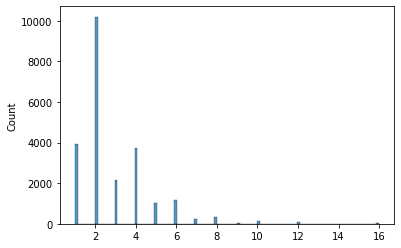

In [ ]:
import seaborn as sns

vals = train['accommodates'].values

print(sns.histplot(vals))
print(pd.Series(vals).describe())

In [ ]:
#based on domain knowledge & about the hist grouping (show the difference)
#bins: 1-2, 3-4, 5-6, everything else
def get_bins_mean(df):
    vals = df['accommodates'].values
    bathrooms = df['bathrooms_text'].values
    bins_dct = {'1-4':[], '5-6':[], 'else':[]}
    for j in range(len(vals)):
        i = vals[j]
        currb = bathrooms[j]
        if type(currb) != float or currb != currb:
            continue
        if i >= 1 and i <= 4:
            bins_dct['1-4'].append(currb)
        elif i >= 5 and i <= 6:
            bins_dct['5-6'].append(currb)
        else:
            bins_dct['else'].append(currb)

    for i in bins_dct:
        bins_dct[i] = np.mean(bins_dct[i])

    return bins_dct

bathroom_bins_dct = get_bins_mean(train)
bathroom_bins_dct

{'1-4': 1.111844416562108,
 '5-6': 1.3925638686131387,
 'else': 1.9763736263736265}

In [ ]:
#fill up with corresponding means
def bin_bathrooms(row):
    if type(row['bathrooms_text']) == float and row['bathrooms_text'] == row['bathrooms_text']:
        return row['bathrooms_text']  
    currac = row['accommodates']
    if currac >= 1 and currac <= 4:
        return 1
    elif currac >= 5 and currac <= 6:
        return 1.5
    else:
        return 2

train['bathrooms_text'] = train.apply(bin_bathrooms, axis = 1)
val['bathrooms_text'] = val.apply(bin_bathrooms, axis = 1)
test['bathrooms_text'] = test.apply(bin_bathrooms, axis = 1)

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

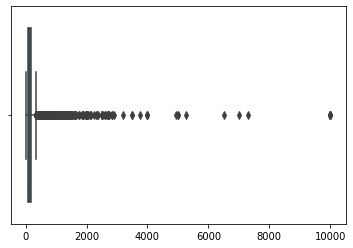

In [ ]:
#to decide cut off value for price to remove extreme listings
import seaborn as sns

sns.boxplot(train['price'].values)

In [ ]:
train['price'].describe()

count    23097.000000
mean       159.636187
std        282.124481
min         10.000000
25%         65.000000
50%        107.000000
75%        177.000000
max      10000.000000
Name: price, dtype: float64

In [ ]:
from matplotlib.cbook import boxplot_stats  

outliers = list(boxplot_stats(train['price'])[0]['fliers'])
outliers.sort()
print(outliers)

[346.0, 346.0, 346.0, 347.0, 347.0, 347.0, 347.0, 347.0, 347.0, 348.0, 348.0, 348.0, 348.0, 348.0, 348.0, 348.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 349.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0, 350.0

In [ ]:
threshold = 1000
train_vals = train['price'].values
val_vals = val['price'].values
test_vals = test['price'].values
train_left = 0
val_left = 0
test_left = 0
for i in train_vals:
    if i < threshold:
        train_left += 1
for i in val_vals:
    if i < threshold:
        val_left += 1
for i in test_vals:
    if i < threshold:
        test_left += 1
print([train_left, val_left, test_left])

train = train[train['price'] < threshold]
val = val[val['price'] < threshold]
test = test[test['price'] < threshold]

print([train.shape, val.shape, test.shape])

[25039, 5368, 5371]
[(25039, 55), (5368, 55), (5371, 55)]


In [ ]:
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

lemmatizer = WordNetLemmatizer()
# pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
# txt = pattern.sub('', txt)
def clean_text(txt):
    txt = txt.translate(str.maketrans('', '', string.punctuation))
    txt = re.sub(r'[^\w\s]','',txt)
    txt = txt.lower()
    txt = nltk.word_tokenize(txt)
    txt = ' '.join(lemmatizer.lemmatize(w) for w in txt) #remove stopwords later
    return txt

In [ ]:
#fill in missing values
# def fill_mean(df, col_name):
#     tot = 0
#     for i in df[col_name]:
#         if i != 'No Data' and i == i:
#             tot += float(i)
#     mean = float(tot) / df.shape[0]
#     df[col_name] = df[col_name].apply(lambda x: mean if x == 'No Data' or x != x else float(x))
#     return mean, df

# def fill_mean_val_test(df, col_name, mean):
#     df[col_name] = df[col_name].apply(lambda x: mean if x == 'No Data' or x != x else float(x))
#     return df

# mean, train = fill_mean(train, 'host_response_rate')
# val = fill_mean_val_test(val, 'host_response_rate', mean)
# test = fill_mean_val_test(test, 'host_response_rate', mean)
# mean, train = fill_mean(train, 'host_acceptance_rate')
# val = fill_mean_val_test(val, 'host_acceptance_rate', mean)
# test = fill_mean_val_test(test, 'host_acceptance_rate', mean)
def fill_zeroes(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: 0 if x == 'No Data' or x != x else float(x))
    return df

train = fill_zeroes(train, 'host_response_rate')
val = fill_zeroes(val, 'host_response_rate')
test = fill_zeroes(test, 'host_response_rate')
train = fill_zeroes(train, 'host_acceptance_rate')
val = fill_zeroes(val, 'host_acceptance_rate')
test = fill_zeroes(test, 'host_acceptance_rate')

In [ ]:
#Standardising the numerical columns
means_sd_dict = {} #to recover the means and sd used to standardise each feature
def standardise_train(df, col_name):
    mean = np.mean(df[col_name])
    sd = np.std(df[col_name])
    df[col_name] = df[col_name].apply(lambda x: (x - mean) / sd)
    means_sd_dict[col_name] = [mean, sd]
    return df

def standardise_val_test(df, col_name):
    mean = means_sd_dict[col_name][0]
    sd = means_sd_dict[col_name][1]
    df[col_name] = df[col_name].apply(lambda x: (x - mean) / sd)
    return df

numerical_features = ['host_months', 'host_response_rate', 'host_acceptance_rate', 
'host_listings_count', 'accommodates', 'bedrooms', 'beds', 'latitude', 'longitude', 'price', 
'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 
'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 
'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value', 'calculated_host_listings_count', 'dist_to_subway']
for feat in numerical_features:
    train = standardise_train(train, feat)
    val = standardise_val_test(val, feat)
    test = standardise_val_test(test, feat)

In [ ]:
#One hot encoding the categorical columns
from sklearn.preprocessing import OneHotEncoder
ohe_dict = {} #store the ohes to transform the val and test correctly
feat_train_dict = {} #store all sparse matrices from the ohe. Will do hstack later
feat_val_dict = {}
feat_test_dict = {}
def one_hot_train(df, col_name):
    enc = OneHotEncoder(drop = 'first')
    vals = df[col_name].values.reshape(-1, 1)
    if 'no data' not in df[col_name].unique():
        label_to_change = df[col_name].value_counts().index[-1]
        for i in range(len(vals)):
            if vals[i] == label_to_change:
                vals[i] = 'no data'
    trf = enc.fit_transform(vals)
    feat_train_dict[col_name] = trf
    ohe_dict[col_name] = enc
    return

def one_hot_val(df, col_name):
    enc = ohe_dict[col_name]
    curr_cats = enc.categories_[0]
    vals = df[col_name].values.reshape(-1, 1)
    for i in range(len(vals)):
        if vals[i] not in curr_cats:
            vals[i] = 'no data'
    trf = enc.transform(vals)
    feat_val_dict[col_name] = trf
    return

def one_hot_test(df, col_name):
    enc = ohe_dict[col_name]
    curr_cats = enc.categories_[0]
    vals = df[col_name].values.reshape(-1, 1)
    for i in range(len(vals)):
        if vals[i] not in curr_cats:
            vals[i] = 'no data'
    trf = enc.transform(vals)
    feat_test_dict[col_name] = trf
    return 

categorical_features = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 
'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
'property_type', 'room_type', 'has_availability', 'instant_bookable']
for feat in categorical_features:
    train[feat] = train[feat].apply(clean_text)
    one_hot_train(train, feat)
    val[feat] = val[feat].apply(clean_text)
    one_hot_val(val, feat)
    test[feat] = test[feat].apply(clean_text)
    one_hot_test(test, feat)

In [ ]:
tot = 0

#ohe_encs = list(ohe_dict.keys())
for i in feat_train_dict:
    tot += feat_train_dict[i].shape[1]
    #tot += len(ohe_dict[i].categories_[0])
    # print(feat_train_dict[i].shape[1])
    # print(len(ohe_dict[ohe_encs[0]].categories_[0]) - 1)
    # print(ohe_dict[ohe_encs[0]].categories_)
    # break

tot

480

In [ ]:
#handle bathrooms_text (apply thermometer encoding)
def thermometer_encoding_train(df, col_name):
    vals = df[col_name].values
    unique = sorted(df[col_name].unique())
    full = np.zeros((df.shape[0], len(unique)))
    for i in range(len(vals)):
        curr = vals[i]
        idx = np.where(curr == unique)[0][0] + 1
        full[i,:idx] = 1
    full = full[:,1:]
    full = sparse.csr_matrix(full)
    feat_train_dict[col_name] = full
    return unique

def thermometer_encoding_val(df, col_name, unique):
    vals = df[col_name].values
    full = np.zeros((df.shape[0], len(unique)))
    for i in range(len(vals)):
        curr = vals[i]
        idx = np.where(curr == unique)[0][0] + 1
        full[i,:idx] = 1
    full = full[:,1:]
    full = sparse.csr_matrix(full)
    feat_val_dict[col_name] = full
    return

def find_index(arr, num):
    idx = 0
    while idx < len(arr):
        if arr[idx] > num:
            return idx
        idx += 1
    idx -= 1
    return idx

def thermometer_encoding_test(df, col_name, unique):
    vals = df[col_name].values
    full = np.zeros((df.shape[0], len(unique)))
    for i in range(len(vals)):
        curr = vals[i]
        try:
            idx = np.where(curr == unique)[0][0] + 1
        except Exception: #unseen number, have to round up, cannot have 'Others' as a category
            idx = find_index(unique, curr) + 1
        full[i,:idx] = 1
    full = full[:,1:]
    full = sparse.csr_matrix(full)
    feat_test_dict[col_name] = full
    return

unique = thermometer_encoding_train(train, 'bathrooms_text')
thermometer_encoding_val(val, 'bathrooms_text', unique)
thermometer_encoding_test(test, 'bathrooms_text', unique)

# train['bathrooms_text'] = train['bathrooms_text'].apply(str)
# val['bathrooms_text'] = val['bathrooms_text'].apply(str)
# test['bathrooms_text'] = test['bathrooms_text'].apply(str)
# one_hot_train(train, 'bathrooms_text')
# one_hot_val(val, 'bathrooms_text')
# one_hot_test(test, 'bathrooms_text')

# mean, train = fill_mean(train, 'bathrooms_text')
# val = fill_mean_val_test(val, 'bathrooms_text', mean)
# test = fill_mean_val_test(test, 'bathrooms_text', mean)
# train = standardise_train(train, 'bathrooms_text')
# val = standardise_val_test(val, 'bathrooms_text')
# test = standardise_val_test(test, 'bathrooms_text')

In [ ]:
feat_train_dict['bathrooms_text'].shape

(25039, 20)

In [ ]:
#clean amenities_str first
def clean_amenities(txt):
    if txt != txt:
        return []
    lst = []
    for i in txt[1:-1].split(','):
        lst.append(clean_text(i))
    return lst

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
#Multi hot encoded vector for amenities
mhe_dict = {} #store the mhes to transform the val and test correctly
mhe_train_dict = {} #store all sparse matrices from the mhe. Will do hstack later
mhe_val_dict = {}
mhe_test_dict = {}

def multi_hot_train(df, col_name):
    mlb = MultiLabelBinarizer(sparse_output = True)
    vals = df[col_name].values
    for i in range(len(vals)):
        # if type(vals[i]) != list:
        vals[i] = clean_amenities(vals[i])
    trf = mlb.fit_transform(vals)
    mhe_dict[col_name] = mlb
    mhe_train_dict[col_name] = trf
    return

def multi_hot_val(df, col_name):
    mlb = mhe_dict[col_name]
    vals = df[col_name].values
    for i in range(len(vals)):
        vals[i] = clean_amenities(vals[i])
    trf = mlb.transform(vals)
    mhe_val_dict[col_name] = trf
    return

def multi_hot_test(df, col_name):
    mlb = mhe_dict[col_name]
    vals = df[col_name].values
    for i in range(len(vals)):
        vals[i] = clean_amenities(vals[i])
    trf = mlb.transform(vals)
    mhe_test_dict[col_name] = trf
    return

multi_hot_train(train, 'amenities_str')
multi_hot_val(val, 'amenities_str')
multi_hot_test(test, 'amenities_str')

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:875: UserWarning: unknown class(es) ['140 tv with amazon prime video', '2 electric burner electric stove', '26 hdtv with amazon prime video', '27 hdtv with amazon prime video', '30 hdtv with amazon prime video', '32 tv with', '32 tv with netflix', '36 hdtv with amazon prime video', '38 hdtv with netflix', '42 tv with apple tv', '48 tv with roku', '49 hdtv with hbo max', '50 hdtv with premium cable', '59 hdtv with roku', '60 hdtv with standard cable', '60 tv with roku', '65 tv with hbo max', '86 hdtv', 'a variety conditioner', 'aesop malengoetz shampoo', 'aiwa', 'all kind shampoo', 'almond body soap', 'always different body soap', 'always different conditioner', 'always different shampoo', 'amazon alexa bluetooth sound system', 'amfm radio sound system', 'and cantu', 'and conditioner body soap', 'apple bluetooth sound system', 'arganatural coconut oil shampoo', 'artisanal hardmilled natural soap body s

In [ ]:
len(mhe_dict['amenities_str'].classes_)

1917

In [ ]:
#transform the text col
from sklearn.feature_extraction.text import TfidfVectorizer

text_vec = TfidfVectorizer(max_df = 0.5, min_df = 0.005)
text_train = text_vec.fit_transform(train['combined_text'])
text_val = text_vec.transform(val['combined_text'])
text_test = text_vec.transform(test['combined_text'])

In [ ]:
len(text_vec.vocabulary_)

4322

In [ ]:
import pickle

all_features = list(text_vec.get_feature_names_out())
all_features = list(map(lambda x: 'Word ' + str(x), all_features))
# all_features = []

for i in numerical_features:
    if i == 'price':
        continue
    all_features.append('Numerical ' + i)

for i in categorical_features:
    num_cats = feat_train_dict[i].shape[1]
    curr_ohe = ohe_dict[i].categories_[0][1:]
    for j in range(num_cats):
        curr = "Categorical " + i + " " + str(curr_ohe[j])
        all_features.append(curr)

num_cats = feat_train_dict['bathrooms_text'].shape[1]
unique = sorted(train['bathrooms_text'].unique())[1:]
for j in range(num_cats):
    curr = 'Categorical bathrooms_text '+ str(unique[j])
    all_features.append(curr)

num_cats = mhe_train_dict['amenities_str'].shape[1]
curr_mhe = mhe_dict['amenities_str'].classes_
for j in range(num_cats):
    curr = 'Categorical amenities_str '+str(curr_mhe[j])
    all_features.append(curr)

features_dict = {}
for i in range(len(all_features)):
    features_dict[i] = all_features[i]

with open('NY_SG_no_review_ratings_feat_dict.pkl', 'wb') as f:
    pickle.dump(features_dict, f)

In [ ]:
len(features_dict)

6763

In [ ]:
#stacking everything together
def get_X(text, df, feat_dict, mhe_dict):
    X = text
    # X = sparse.csr_matrix(np.array(df[numerical_features[0]]).reshape(df.shape[0], 1))
    print(X.shape)
    for i in numerical_features:
        if i == 'price':
            continue
        X = sparse.hstack((X, np.array(df[i]).reshape(-1, 1)))
    print(X.shape)
    for i in categorical_features:
        X = sparse.hstack((X, feat_dict[i]))
    print(X.shape)
    # X = sparse.hstack((X, np.array(df['bathrooms_text']).reshape(-1, 1)))
    X = sparse.hstack((X, feat_dict['bathrooms_text']))
    print(X.shape)
    X = sparse.hstack((X, mhe_dict['amenities_str']))
    print(X.shape)
    return X

def get_Y(df):
    return df['price']

X_train = get_X(text_train, train, feat_train_dict, mhe_train_dict)
y_train = get_Y(train)
X_val = get_X(text_val, val, feat_val_dict, mhe_val_dict)
y_val = get_Y(val)
X_test = get_X(text_test, test, feat_test_dict, mhe_test_dict)
y_test = get_Y(test)

print([X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape])

(25039, 4322)
(25039, 4346)
(25039, 4826)
(25039, 4846)
(25039, 6763)
(5368, 4322)
(5368, 4346)
(5368, 4826)
(5368, 4846)
(5368, 6763)
(5371, 4322)
(5371, 4346)
(5371, 4826)
(5371, 4846)
(5371, 6763)
[(25039, 6763), (25039,), (5368, 6763), (5368,), (5371, 6763), (5371,)]


text = combined_text

numerical = host_months, host_response_rate, host_acceptance_rate, host_listings_count, latitude, longitude, accommodates, bedrooms, beds, minimum_nights, maximum_nights, availability_30, availability_60, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, calculated_host_listings_count

categorical = host_response_time, host_is_superhost, host_has_profile_pic, host_identity_verified, neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed, property_type, room_type, has_availability, instant_bookable

special treatment: bathrooms_text (fill in with mean), amenities_str (categorical, multi-hot vector)

In [ ]:
import pickle

with open('NY_SG_no_review_ratings_x_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open('NY_SG_no_review_ratings_y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open('NY_SG_no_review_ratings_x_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)

with open('NY_SG_no_review_ratings_y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)

with open('NY_SG_no_review_ratings_x_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('NY_SG_no_review_ratings_y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
means_sd_dict['price'] #to recover the predictions after modelling

[142.32670802026908, 120.8693951814902]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2a92d0af-cecf-4cde-96f5-c3db3a7f88f1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>